In [3]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import mlflow
from datasets import load_dataset, DatasetDict, ClassLabel
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from IPython.core.display_functions import clear_output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)


In [5]:
import pandas as pd
val_df = pd.read_csv('../twitter_fsa/data/validation_cleaned.csv')

In [29]:
def get_sample_weight_dict(df):
    rating_counts = df['label'].value_counts()
    print(f"rating value counts === {rating_counts}")
    max_rating_count = rating_counts.max()
    print(f"max rating count === {max_rating_count}")
    weight_dict = (max_rating_count / rating_counts).to_dict()
    print(f"weight_dict === {weight_dict}")
    return weight_dict

sample_weight_dict = get_sample_weight_dict(val_df)

rating value counts === label
2    1252
1     380
0     278
Name: count, dtype: int64
max rating count === 1252
weight_dict === {2: 1.0, 1: 3.294736842105263, 0: 4.503597122302159}


In [25]:
sample_weights = [1.0] * 3
for key,weight in sample_weight_dict.items():
    sample_weights[key] = weight
sample_weights

[4.503597122302159, 3.294736842105263, 1.0]

In [8]:
chkpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(chkpt)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device : {device}")


device : cuda


In [12]:
experiment_name = "Financial Sentiment Analysis"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///D:/aiML/NLP/llms/financial_semtiment_analysis/fsa/twitter_fsa/mlruns/302840273348095459', creation_time=1770183880178, experiment_id='302840273348095459', last_update_time=1770183880178, lifecycle_stage='active', name='Financial Sentiment Analysis', tags={}>

In [6]:
train_dataset = load_dataset("csv",data_files="data/train_cleaned.csv")["train"]
val_dataset = load_dataset("csv",data_files="data/validation_cleaned.csv")["train"]
# label_mapping = {
#     0: "Negative", #"Bearish", 
#     1: "Positive", # "Bullish", 
#     2: "Neutral", #"Neutral"
# }

class_labels = ClassLabel(num_classes=3, names = ["bearish", "bullish", "neutral"])
train_dataset = train_dataset.cast_column("label",class_labels)
val_dataset = val_dataset.cast_column("label",class_labels)

# rename the column for compatability with transformers classification head
train_dataset = train_dataset.rename_column("label","labels")
val_dataset = val_dataset.rename_column("label","labels")

Generating train split: 0 examples [00:00, ? examples/s]

Casting the dataset:   0%|          | 0/9508 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1910 [00:00<?, ? examples/s]

In [9]:
train_tokenized =train_dataset.map(lambda batch: tokenizer(batch["text"], padding=True), 
                                   batched=True, batch_size=64)
print(train_tokenized.features)
val_tokenized = val_dataset.map(lambda batch: tokenizer(batch["text"], padding=True), 
                                   batched=True, batch_size=64)
print(val_tokenized.features)

Map:   0%|          | 0/9508 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['bearish', 'bullish', 'neutral'], id=None), 'word_count': Value(dtype='int64', id=None), 'char_count': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


Map:   0%|          | 0/1910 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['bearish', 'bullish', 'neutral'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [16]:
def compute_metrics(preds):
    y_pred = preds.predictions.argmax(axis=-1)
    labels = preds.label_ids
    f1_weighted = f1_score(y_true=labels, y_pred=y_pred, average='weighted')
    precision_weighted = precision_score(y_true=labels, y_pred=y_pred, average='weighted')
    recall_weighted = recall_score(y_true=labels, y_pred=y_pred, average='weighted')
    accuracy = balanced_accuracy_score(y_true=labels, y_pred=y_pred)
    f1_macro = f1_score(y_true=labels, y_pred=y_pred, average='macro')
    precision_macro = precision_score(y_true=labels, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true=labels, y_pred=y_pred, average='macro')
    metrics = {
        "f1_weighted": f1_weighted, 
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted, 
        "precision_macro": precision_macro,
        "recall_weighted": recall_weighted, 
        "recall_macro": recall_macro,
        "accuracy": accuracy,
    }    
    return metrics


In [27]:
from torch import nn
def weighted_loss(self, model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    # Forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    weights = torch.tensor(sample_weights).to(model.device)
    loss_fct = nn.CrossEntropyLoss(weight=weights)
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))    
    return (loss, outputs) if return_outputs else loss

In [28]:
# artificat_path = "distill_bert_layer_5"
artificat_path = "distill_bert_layer_4"
def tune_model(training_params):
    model = AutoModelForSequenceClassification.from_pretrained(chkpt, num_labels=3).to(device)
    for encoder_layer, (name,param) in enumerate(model.named_parameters()):
       # if encoder_layer < 84: # encoder layer 5
       if encoder_layer < 68: #encoder layer 4
           param.requires_grad = False
       else:
           param.requires_grad = True
            
    training_args = TrainingArguments(
        "distil_bert_freeze",
        eval_strategy="epoch",
        learning_rate = training_params["learning_rate"],
        num_train_epochs=training_params["num_train_epochs"],
        remove_unused_columns=True,
        weight_decay= training_params["weight_decay"],
        lr_scheduler_type=training_params["lr_scheduler"],
        warmup_ratio=training_params["warmup_ratio"],
        load_best_model_at_end=True,     
        metric_for_best_model="eval_accuracy", 
        greater_is_better=True,
        save_strategy="epoch",
        save_total_limit=2
    )
    trainer = Trainer(
        model=model,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        args=training_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        compute_loss_func= weighted_loss,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
   
    with mlflow.start_run(nested=True) as _:        
        trainer.train()
        model.eval()
        val_predictions = trainer.predict(val_tokenized)
        model_tokenizer = {
            "model": model,
            "tokenizer": tokenizer,
        }
        metrics = compute_metrics(val_predictions)
        metrics["loss"] = -metrics["accuracy"]
        print(training_params)
        print(metrics)
        # mlflow.log_params(training_args)
        mlflow.log_metrics(metrics)
        mlflow.transformers.log_model(transformers_model=model_tokenizer, name=artificat_path, task="text-classification")        
        metrics["status"] = STATUS_OK
        return metrics

In [11]:
def fine_tune_model(ml_flow_run_name, search_space):
    with mlflow.start_run(run_name=ml_flow_run_name):
        # Run optimization
        trials = Trials()
        best_params = fmin(
            fn=tune_model,
            space=search_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials,
            verbose=True,
        )
        # Find and log best results
        best_trial = min(trials.results, key=lambda x: x["loss"])
        # Log optimization results
        mlflow.log_params(best_params)
        mlflow.log_metrics(
            {
                "best_val_log_loss": best_trial["loss"],
                 "best_accuracy": best_trial["accuracy"],
                "best_precision": best_trial["precision"],
                "best_recall" : best_trial["recall"],
                "best_f1": best_trial["f1"],
                "total_trials": len(trials.trials),
                "optimization_completed": 1,
            }
        )
        print(best_params)

In [6]:
search_space = {
   "learning_rate": hp.uniform("learning_rate", 1e-5, 5e-5),
    "num_train_epochs": hp.uniform("num_train_epochs", 2, 5),
   "weight_decay": hp.uniform("weight_decay", 0.01, 0.1),
    "lr_scheduler": hp.choice("lr_scheduler", ["cosine", "linear"]),
    "warmup_ratio": hp.choice("warmup_ratio", [0.0, 0.05, 0.1]),
}
fine_tune_model("hyper_parameter_search", search_space)
clear_output(wait=True)

NameError: name 'fine_tune_model' is not defined

In [20]:
trained_model = AutoModelForSequenceClassification.from_pretrained("best_model/distill_bert_layer_5/fine_tune_1/model")
trained_model.eval()
trained_model.to(device)

saved_tokenizer = AutoTokenizer.from_pretrained("best_model/distill_bert_layer_5/fine_tune_1/components/tokenizer")


In [21]:
eval_args = TrainingArguments(
    output_dir="./temp_inference",
    per_device_eval_batch_size=64,
)

trainer = Trainer(
    model=trained_model,
    args=eval_args,
    tokenizer=saved_tokenizer
)
output = trainer.predict(val_tokenized)
metrics = compute_metrics(output)
metrics

{'f1_weighted': 0.8494747586116967,
 'f1_macro': 0.7959245032333341,
 'precision_weighted': 0.8493210066118065,
 'precision_macro': 0.7983904676513972,
 'recall_weighted': 0.849738219895288,
 'recall_macro': 0.7936901059277011,
 'accuracy': 0.7936901059277011}

Now we use the confusion matrix to look into the predicted and true labels.
We look at it from 2 perspectives.
1) Normalize=true(row-wise, based on true labels), out of all the "Bearish" tweets, how much did the model correctly predict as "Bearish". This nothing but the recall.
2) Normalize = pred(column-wise, based on predicted labels), out of all the "Bearish" predictions made by the model, how much are actually "Bearish". This is the precision of the model. When mu model makes a prediction as "Bearish", how confident can i be that the tweet is actually "Bearish".

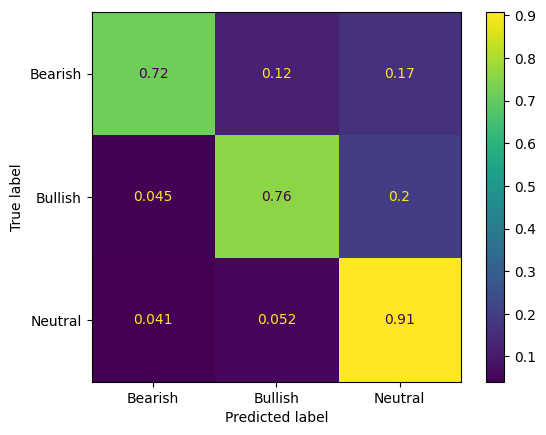

In [43]:
y_pred = output.predictions.argmax(axis=-1)
labels = output.label_ids

cm = confusion_matrix(labels, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()

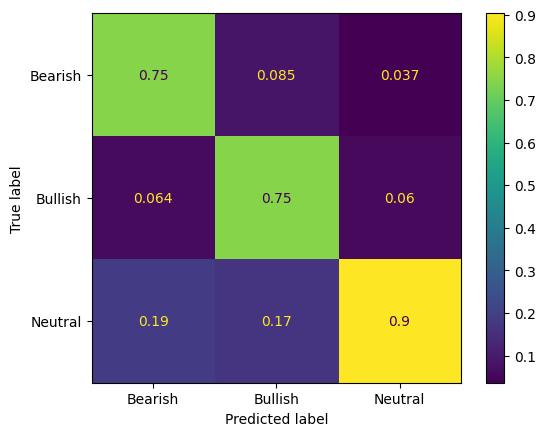

In [44]:
cm = confusion_matrix(labels, y_pred, normalize="pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()

In [12]:
%%capture
search_space_2 = {
   "learning_rate": hp.uniform("learning_rate", 3e-5, 5e-5),
    "num_train_epochs": hp.uniform("num_train_epochs", 2, 4),
   "weight_decay": hp.uniform("weight_decay", 0.06, 0.08),
    "lr_scheduler": hp.choice("lr_scheduler", ["linear"]),
    "warmup_ratio": hp.choice("warmup_ratio", [0.0, 0.05, 0.1]),
}
fine_tune_model("hyper_parameter_search_step_2", search_space_2)

NameError: name 'tune_model' is not defined

In [18]:
trained_model = AutoModelForSequenceClassification.from_pretrained(
    "../twitter_fsa/best_model/distill_bert_layer_5/fine_tune_2/model")
trained_model.eval()
trained_model.to(device)

saved_tokenizer = AutoTokenizer.from_pretrained("../twitter_fsa/best_model/distill_bert_layer_5/fine_tune_2/components/tokenizer")

eval_args = TrainingArguments(
    output_dir="./temp_inference",
    per_device_eval_batch_size=64,
)

trainer = Trainer(
    model=trained_model,
    args=eval_args,
    tokenizer=saved_tokenizer
)
output = trainer.predict(val_tokenized)
metrics = compute_metrics(output)
metrics

{'f1_weighted': 0.851227184925707,
 'f1_macro': 0.8000884551622308,
 'precision_weighted': 0.8511990399301476,
 'precision_macro': 0.8011677708670533,
 'recall_weighted': 0.8513089005235602,
 'recall_macro': 0.7991200851324994,
 'accuracy': 0.7991200851324994}

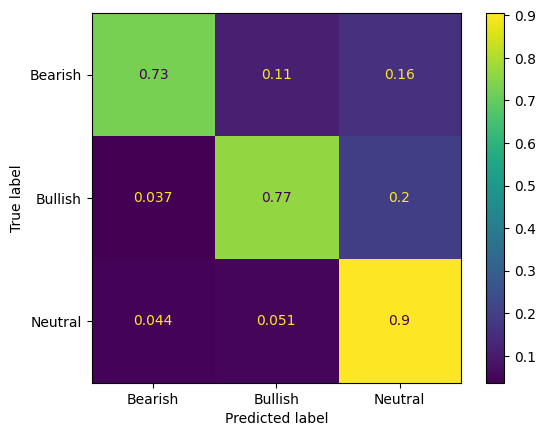

In [48]:
y_pred = output.predictions.argmax(axis=-1)
labels = output.label_ids

cm = confusion_matrix(labels, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()

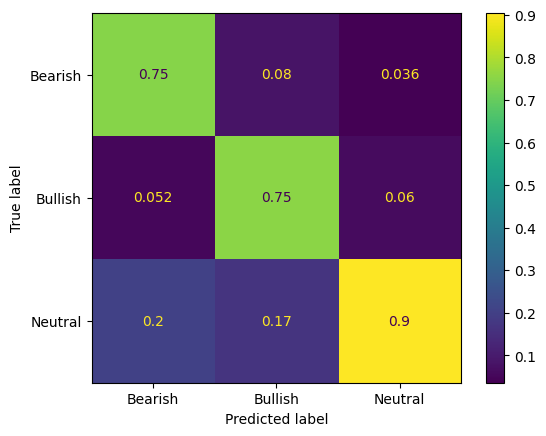

In [49]:
y_pred = output.predictions.argmax(axis=-1)
labels = output.label_ids

cm = confusion_matrix(labels, y_pred, normalize="pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()

In [2]:
search_space_unfreeze_layer_4 = {
   "learning_rate": hp.uniform("learning_rate", 1e-5, 5e-5),
    "num_train_epochs": hp.uniform("num_train_epochs", 2, 5),
   "weight_decay": hp.uniform("weight_decay", 0.01, 0.1),
    "lr_scheduler": hp.choice("lr_scheduler", ["cosine", "linear"]),
    "warmup_ratio": hp.choice("warmup_ratio", [0.0, 0.05, 0.1]),
}
fine_tune_model("unfreeze_layer_4", search_space_unfreeze_layer_4)

NameError: name 'hp' is not defined

In [17]:
trained_model = AutoModelForSequenceClassification.from_pretrained("best_model/distill_bert_layer_4/fine_tune_1/model")
trained_model.eval()
trained_model.to(device)

saved_tokenizer = AutoTokenizer.from_pretrained("best_model/distill_bert_layer_4/fine_tune_1/components/tokenizer")

eval_args = TrainingArguments(
    output_dir="./temp_inference",
    per_device_eval_batch_size=64,
)

trainer = Trainer(
    model=trained_model,
    args=eval_args,
    tokenizer=saved_tokenizer
)
output = trainer.predict(val_tokenized)
metrics = compute_metrics(output)
metrics

{'f1_weighted': 0.8685254855474881,
 'f1_macro': 0.8223033107964062,
 'precision_weighted': 0.870052985333269,
 'precision_macro': 0.8157211539920551,
 'recall_weighted': 0.8675392670157068,
 'recall_macro': 0.8299516230298088,
 'accuracy': 0.8299516230298088}

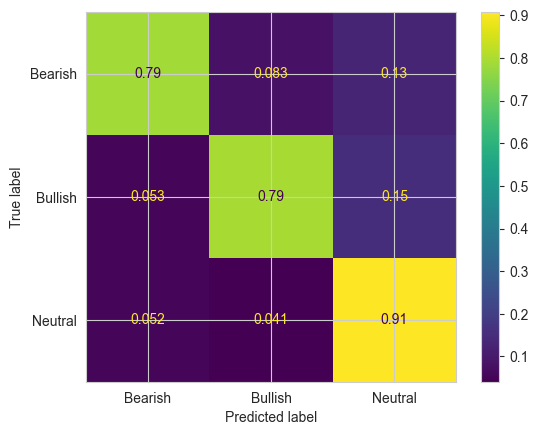

In [14]:
y_pred = output.predictions.argmax(axis=-1)
labels = output.label_ids

cm = confusion_matrix(labels, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()

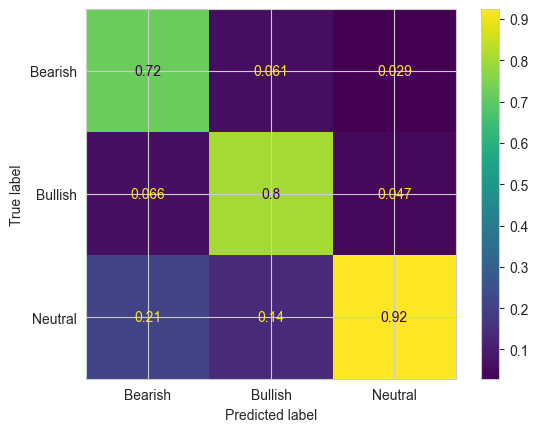

In [15]:
y_pred = output.predictions.argmax(axis=-1)
labels = output.label_ids

cm = confusion_matrix(labels, y_pred, normalize="pred")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Bearish", "Bullish", "Neutral"])
disp.plot()
plt.show()